In [30]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import matplotlib as mpl

In [31]:
# 处理一些冲突
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 该语句解决图像中的“-”负号的乱码问题

In [32]:
# 数据读取
humidity = pd.read_excel('./dataset/3-humidity.xls')  # 湿度数据
bio_amount = pd.read_excel('./dataset/15-plant-bio.xlsx', sheet_name='2016-2020物种数据库')  # 生物量数据
bio_amount = bio_amount.drop('Unnamed: 15', axis=1)  # 去除多余的一列

In [33]:
"""
由于生物量只有5，6，7，8，9月这几个月的数据
同样湿度数据也只取这几个月的数据
"""
# print(humidity.info())
months = [5, 6, 7, 8, 9]
humidity_sub = humidity[humidity['月份'].isin(months)]
humidity_sub.pop('经度(lon)')
humidity_sub.pop('纬度(lat)')

humidity_sub.columns

Index(['月份', '年份', '10cm湿度(kg/m2)', '40cm湿度(kg/m2)', '100cm湿度(kg/m2)',
       '200cm湿度(kg/m2)'],
      dtype='object')

In [34]:
# 将生物量的日期转为月份
# 提取月份, 注意到有一个6月1号的数据，可以将看作5月的数据(特殊处理)
bio_amount['月份'] = bio_amount['日期'] \
    .apply(lambda x: int(x.split('.')[1]) if int(x.split('.')[2]) != 1 else int(x.split('.')[1]) - 1) \
    .astype('int64')  # 这里要注意数据是str类型，所以要转化为int类型，不然不能进行数据运算，导致结果有问题

In [35]:
# merge数据
all_df = bio_amount.merge(humidity_sub, on=['年份', '月份'], how='left')
all_df['年份'] = all_df['年份'].astype('str')

# 只保留需要的列
needs = ['年份', '月份', '轮次', '处理', '植物种名', '干重(g)', '10cm湿度(kg/m2)',
         '40cm湿度(kg/m2)', '100cm湿度(kg/m2)', '200cm湿度(kg/m2)']
all_df = all_df[needs]

In [40]:
bio_amount_process_stags = all_df.groupby(['年份', '月份', '处理']).agg({'10cm湿度(kg/m2)':sum, '40cm湿度(kg/m2)':sum, '100cm湿度(kg/m2)':sum,
    '200cm湿度(kg/m2)':sum , '干重(g)': sum
}).reset_index()
list_sorted = ['无牧（0天）', '轻牧（3天）', '中牧（6天）', '重牧（12天）']
bio_amount_process_stags['处理'] = bio_amount_process_stags['处理'].astype('category').cat.set_categories(list_sorted)  # 自定义排序
bio_amount_process_stags = bio_amount_process_stags.sort_values(by=['年份', '月份', '处理'], ascending=True)

bio_amount_process_stags

,年份,月份,处理,10cm湿度(kg/m2),40cm湿度(kg/m2),100cm湿度(kg/m2),200cm湿度(kg/m2),干重(g)
1,2016,5,无牧（0天）,1326.98,3645.54,4085.00,14407.58,870.16
2,2016,5,轻牧（3天）,1188.11,3264.03,3657.50,12899.81,1047.21
0,2016,5,中牧（6天）,1373.27,3772.71,4227.50,14910.17,1067.33
3,2016,5,重牧（12天）,987.52,2712.96,3040.00,10721.92,861.18
5,2016,6,无牧（0天）,1530.00,3915.00,4284.00,15075.00,1463.34
...,...,...,...,...,...,...,...,...
95,2020,8,重牧（12天）,3575.88,9740.36,11785.44,28639.72,2301.29
97,2020,9,无牧（0天）,2004.00,5667.00,7604.00,16632.00,2691.88
98,2020,9,轻牧（3天）,3106.20,8783.85,11786.20,25779.60,4246.77
96,2020,9,中牧（6天）,2705.40,7650.45,10265.40,22453.20,3445.48


In [42]:
bio_amount_process_stags['处理'] = bio_amount_process_stags['处理'].map({'无牧（0天）':'NG','轻牧（3天）': 'LGI',
                                                                     '中牧（6天）': 'MGI','重牧（12天）': 'HGI'})
bio_amount_process_stags

,年份,月份,处理,10cm湿度(kg/m2),40cm湿度(kg/m2),100cm湿度(kg/m2),200cm湿度(kg/m2),干重(g)
1,2016,5,NG,1326.98,3645.54,4085.00,14407.58,870.16
2,2016,5,LGI,1188.11,3264.03,3657.50,12899.81,1047.21
0,2016,5,MGI,1373.27,3772.71,4227.50,14910.17,1067.33
3,2016,5,HGI,987.52,2712.96,3040.00,10721.92,861.18
5,2016,6,NG,1530.00,3915.00,4284.00,15075.00,1463.34
...,...,...,...,...,...,...,...,...
95,2020,8,HGI,3575.88,9740.36,11785.44,28639.72,2301.29
97,2020,9,NG,2004.00,5667.00,7604.00,16632.00,2691.88
98,2020,9,LGI,3106.20,8783.85,11786.20,25779.60,4246.77
96,2020,9,MGI,2705.40,7650.45,10265.40,22453.20,3445.48


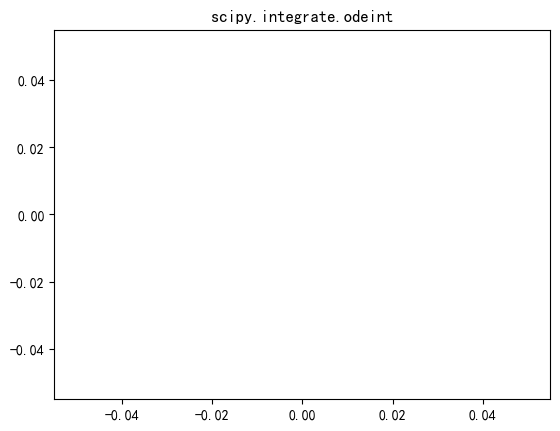

In [28]:
# 1. 求解微分方程初值问题(scipy.integrate.odeint)
from scipy.integrate import odeint  # 导入 scipy.integrate 模块
import numpy as np
import matplotlib.pyplot as plt

def dy_dt(y, t):  # 定义函数 f(y,t)
    return 0.049*y*(1-y/4000)-0.0047*y

y0 = [1]  # y0 = 1 也可以
t = np.arange(20160
y = odeint(dy_dt, y0, t)  # 求解微分方程初值问题

# 绘图
plt.plot(t, y)
plt.title("scipy.integrate.odeint")
plt.show()